#### Classification | Model

# Predicting Heart Disease  

## Classification Model Stepwise Analysis <a id='top'></a> 

1. [Research Question](#1)<br/>
2. [DataFrames](#2) <br/>
3. [Exporatory Data Analysis](#3)<br/>
    Summarize<br/>
    Classification Viability<br/>
    Classification Metrics<br/>
4. [Baselining](#4)<br/>
5. [Validation](#5)<br/>
6. [Model Iterations](#6) <br/>
    model 1<br/>
    model 1<br/>
    model 1<br/>
    model 1<br/>
    model 1<br/>
    model 1<br/>
    [Feature Engineering](#68)<br/>
    Class Imbalance<br/>
7. [Model Selection ](#7)<br/>



In [128]:
import pandas as pd
import numpy as np
import imblearn.over_sampling
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) 
sns.set_style("whitegrid")

from imblearn.under_sampling import RandomUnderSampler
# from ipywidgets import interactive, FloatSlider
from mlxtend.classifier import StackingClassifier 
from plotly.subplots import make_subplots
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC ,SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle





## 1 | Research Design<a id='1'></a> 

* **Reserach Question:** How might we predict which patients are at high risk of heart disease?
* **Impact Hypothesis:** Reduce the number of patients who develop heart disease (arterial plaque or heart attack).
* **Data source:** [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease), n=319,795
* **Error metric:** [Recall](#3c) and [ROC AUC](#3c)

#### [Data Dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf)<a id='1a'></a>
_Target_
- `y_heart_disease`: Y/N | coronary heart disease (CHD) or myocardial infarction (MI)

_Health Behaviors_
- `behavior_activity`: Num (0-30) | # days did physical activity/ exercise other than regular job
- `behavior_alcohol`: Y/N | heavy drinker, defined as men: 14+/wk, women: 7+/wk (includes beer, wine, malt beverage, liquor)
- `behavior_sleep`: Num (0-24) | # hours of sleep in a 24-hour period, on average
- `behavior_tobacco`: Y/N | smoked at least 100 cigarettes in your life

_Demographics_
- `demg_age`: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80+
- `demg_gender`: male/female
- `demg_race`: White, Black, Asian, American Indian/Alaskan Native, Hispanic, Other race

_Health Measures_
- `health_bmi`: Num | Body Mass Index (BMI)
- `health_physical`: Num (0-30) | # days physical health  not good, includes physical illness and injury
- `health_mental`: Num (0-30 ) | # days mental health not good, includes stress, depression, and problems with emotions
- `health_general`: Excellent, Very Good, Fair, Poor | Would you say that in general your health is...
- `health_mobility`: Y/N | serious difficulty walking or climbing stairs

_Chronic Disease_
- `disease_asthma`: Y/N
- `disease_diabetes`: Y/N/Y pregnancy/N borderline
- `disease_kidney`: Y/N | kidney disease, excludes kidney stones, bladder infection or incontinence
- `disease_skin`: Y/N | skin cancer
- `disease_stroke`: Y/N

[back to top](#top)

## 2 | [DataFrames](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb)<a id='2'></a>  


In [3]:
# load clean and transformed dataframes from mvp 
heart_disease_df = pd.read_csv('heart_disease_df.csv')
heart_disease_df_map = pd.read_csv('heart_disease_df_map.csv') 


In [ ]:
# clean df
heart_disease_df.head(3)


In [4]:
# transformed df: mapped categorical variables to numerical values 
heart_disease_df_map.head(3)


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,1,0,5.0,1,55,1,6,1,1,0,1,0,16.60,4,30.0,0,3.0,0
1,1,0,7.0,0,80,1,6,0,0,0,0,1,20.34,4,0.0,0,0.0,0
2,1,0,8.0,1,65,2,6,1,1,0,0,0,26.58,2,30.0,0,20.0,0


[back to top](#top)

## 3 | Exporatory Data Analysis<a id='3'></a> 

#### Using `heart_disease_df_map` with mapped variables for modeling.
##### Note: Full EDA part of [MVP](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb).

### 3.1 Summarize data<a id='31'></a> 

In [ ]:
# dataframe info
heart_disease_df_map.info()


#### No missing data, all data types are numerical.

[back to top](#top)

### 3.2 Classification viability<a id='32'></a> 

In [ ]:
# descriptive statistics
heart_disease_df_map.describe().T.style.background_gradient(cmap='Blues')


In [5]:
# correlation matrix
heart_disease_df_map.corr().style.background_gradient(cmap='Blues')


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
behavior_activity,1.000000,0.017487,0.003849,-0.097174,-0.121465,0.048247,0.056767,-0.041526,-0.097539,-0.081827,-0.001328,-0.079455,-0.150616,0.281249,-0.095808,-0.278524,-0.232283,-0.100030
behavior_alcohol,0.017487,1.000000,-0.005065,0.111768,-0.058837,0.004200,0.036702,-0.002202,-0.042695,-0.028280,-0.005702,-0.019858,-0.038816,0.029780,0.051282,-0.035328,-0.017254,-0.032080
behavior_sleep,0.003849,-0.005065,1.000000,-0.030336,0.103071,-0.015704,0.035889,-0.048245,-0.005166,0.006238,0.041266,0.011900,-0.051822,0.063071,-0.119717,-0.022216,-0.061387,0.008327
behavior_tobacco,-0.097174,0.111768,-0.030336,1.000000,0.130384,0.085052,0.065499,0.024149,0.038993,0.034920,0.033977,0.061226,0.023118,-0.174717,0.085157,0.120074,0.115352,0.107764
demg_age,-0.121465,-0.058837,0.103071,0.130384,1.000000,-0.067682,0.162777,-0.058235,0.154070,0.122697,0.262208,0.137280,-0.001740,-0.188236,-0.155455,0.242552,0.110789,0.232325
demg_gender,0.048247,0.004200,-0.015704,0.085052,-0.067682,1.000000,0.018855,-0.069191,-0.018350,-0.009084,0.013434,-0.003091,0.026940,0.025947,-0.100058,-0.068860,-0.040904,0.070040
demg_race,0.056767,0.036702,0.035889,0.065499,0.162777,0.018855,1.000000,-0.017975,-0.056252,0.003709,0.134780,-0.003956,-0.037424,0.057986,-0.014491,-0.015831,-0.000847,0.034854
disease_asthma,-0.041526,-0.002202,-0.048245,0.024149,-0.058235,-0.069191,-0.017975,1.000000,0.044136,0.039707,-0.000396,0.038866,0.092345,-0.137342,0.114008,0.103222,0.117907,0.041444
disease_diabetes,-0.097539,-0.042695,-0.005166,0.038993,0.154070,-0.018350,-0.056252,0.044136,1.000000,0.095186,0.024113,0.072476,0.163437,-0.204278,0.029970,0.152876,0.111644,0.118281
disease_kidney,-0.081827,-0.028280,0.006238,0.034920,0.122697,-0.009084,0.003709,0.039707,0.095186,1.000000,0.061816,0.091167,0.050768,-0.174642,0.037281,0.153064,0.142197,0.145197


#### A classification model is viable.

[back to top](#top)

In [ ]:
# target vs age
ax = sns.boxplot(x='y_heart_disease', y='demg_age', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [ ]:
# target vs mobility
sns.boxplot(x='y_heart_disease', y='health_bmi', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [ ]:
# target vs physical health
sns.boxplot(x='y_heart_disease', y='health_physical', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [ ]:
# target distribution
print('Positives/Negatives Ratio:', round(27373/292422, 4) * 100, '%')
print(heart_disease_df['y_heart_disease'].value_counts())


[back to top](#top)

### 3.3 Classification metrics<a id='33'></a> 

* **Recall** to maximize on patients who are true positives for heart disease.
* **ROC AUC** to identify high vs low risk patients. 

[back to top](#top)

## 4 | Baseline<a id='4'></a> 

#### Logistic regression with three features based on correlation matrix.

In [6]:
# separate target from features based on the correlation matrix
y_base = heart_disease_df_map['y_heart_disease'] 
X_base = heart_disease_df_map.loc[:, [
#     'behavior_activity', 
#     'behavior_alcohol', 
#     'behavior_sleep',
#     'behavior_tobacco',
    'demg_age',
#     'demg_gender', 
#     'demg_race',
#     'disease_asthma', 
#     'disease_diabetes', 
#     'disease_kidney', 
#     'disease_skin', 
#     'disease_stroke', 
#     'health_bmi', 
#     'health_general', 
#     'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

# split baseline data test/train/validate
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base,
                                                                        y_base,
                                                                        test_size=0.2,
                                                                        random_state=42)
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train_base, 
                                                                                y_train_base, 
                                                                                test_size = .25, 
                                                                                random_state = 42)

# scale baseline X train/test
scaler = StandardScaler()
X_train_scaled_base = scaler.fit_transform(X_train_base)
X_test_scaled_base = scaler.transform(X_test_base)
X_val_scaled_base = scaler.transform(X_val_base)


In [9]:
# baseline logistic regression X train scaled & y train
log_reg_base = LogisticRegression().fit(X_train_scaled_base, y_train_base)

# baseline predict on X_validate_scaled_m 
y_pred_base = log_reg_base.predict(X_val_scaled_base) 


# score on X_test_scaled and y_test
print("Baseline logistic regression recall (val):", round(
    recall_score(log_reg_base.predict(X_val_scaled_base), y_val_base), 4))

print("Baseline logistic regression ROC AUC score (val):",  round(
    roc_auc_score(y_val_base, log_reg_base.predict_proba(X_val_scaled_base)[:,1]), 4))



Baseline logistic regression recall (val): 0.36
Baseline logistic regression ROC AUC score (val): 0.7858


[back to top](#top)

## 5 | Validation<a id='5'></a>

#### Validation and testing scheme to use in [model selection](#7). 

In [10]:
# separate target from features 
y = heart_disease_df_map['y_heart_disease'] 
X = heart_disease_df_map.loc[:, [
    'behavior_activity', 
    'behavior_alcohol', 
    'behavior_sleep',
    'behavior_tobacco',
    'demg_age',
    'demg_gender', 
    'demg_race',
    'disease_asthma', 
    'disease_diabetes', 
    'disease_kidney', 
    'disease_skin', 
    'disease_stroke', 
    'health_bmi', 
    'health_general', 
    'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

# split data test/train/validate
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                            y_train, 
                                                            test_size = .25, 
                                                            random_state = 42)

# scale X train/test/validate
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


[back to top](#top)

## 6 | Model Iterations <a id='6'></a> 

- Starting from the baseline and in an iterative, validated loop ask: 
    - Do you need more complexity or less (underfitting vs. overfitting)? 
    - Do you need a fancier model (nonlinear, additional feature engineering / transformations)? 
    - If you need more complexity, try tree-based models such as random forest or gradient boosted trees. 
    - Are you overfitting and need to make your model more conservative by removing features or using regularization? - Hopefully you can quickly acquire an understanding of which direction you need to go in from your baseline and early modeling results, then make more fine-tuned changes as you go.


- The impact of model choices should be consistently measured against the same validation data as in part 3, using your relevant classification performance metrics such as F1 or ROC AUC. 


[back to top](#top)

### 6.1 k-Nearest Neighbors<a id='61'></a> 

In [55]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)
knn

# print("The score for kNN is")
# print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
# print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))



KNeighborsClassifier(n_neighbors=3)

[back to top](#top)

### 6.2 Logistic Regression<a id='62'></a> 

In [13]:
log_reg = LogisticRegression().fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_val_scaled) 

print("Logistic regression recall score (val):", round(
    recall_score(log_reg.predict(X_val_scaled), y_val), 4))
print("Logistic regression ROC AUC score (val):",  round(
    roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1]), 4))



Logistic regression recall score (val): 0.5195
Logistic regression ROC AUC score (val): 0.8411


Logistic regression maybe [model winner](#7), recall score improved from [baseline](#4).<br/>


[back to top](#top)

### 6.3 Decision Trees<a id='63'></a> 

Decision tree (depth=2) recall (val): 0.0
Decision4tree (depth= 2) ROC AUC score (val): 0.5


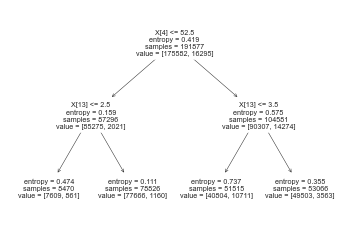

In [23]:
# tree max depth 2
dt_2 = DecisionTreeClassifier(max_depth=2,criterion="entropy")
dt_2.fit(X_train, y_train)
y_pred = dt_2.predict(X_val)

print("Decision tree (depth=2) recall (val):", round(
    recall_score(dt_2.predict(X_val), y_val), 4))
tree.plot_tree(dt_2);

print("Decision4tree (depth= 2) ROC AUC score (val):",  round(
    roc_auc_score(y_val, dt_2.predict_proba(X_val_scaled)[:,1]), 4))


Decision tree (depth=4) recall score (val): 0.0
Decision4tree (depth= 4) ROC AUC score (val): 0.5683


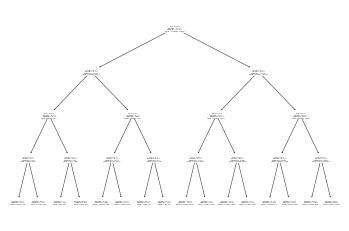

In [24]:
# tree max depth 4
dt_4 = DecisionTreeClassifier(max_depth=4,criterion="entropy")
dt_4.fit(X_train, y_train)
y_pred = dt_4.predict(X_val)

print("Decision tree (depth=4) recall score (val):", round(
    recall_score(dt_4.predict(X_val), y_val), 4))
tree.plot_tree(dt_4);

print("Decision4tree (depth= 4) ROC AUC score (val):",  round(
    roc_auc_score(y_val, dt_4.predict_proba(X_val_scaled)[:,1]), 4))


### 6.4 Random Forests <a id='64'></a> 

In [26]:
forest = RandomForestClassifier().fit(X_train, y_train)
y_pred_rf = forest.predict(X_val)

print("Random forests recall score (val):", round(
    recall_score(forest.predict(X_val), y_val), 4))
print("Random forest ROC AUC score (val):",  round(
    roc_auc_score(y_val, forest.predict_proba(X_val_scaled)[:,1]), 4))


Random forests recall score (val): 0.3689
Random forest ROC AUC score (val): 0.6955


Random forest model performs worse than [logistic regression](#6b). 

[back to top](#top)

### 6.5 Gradient Boosted Trees: xgboost<a id='65'></a> 

In [96]:
# XGBoost

gbm = xgb.XGBRegressor( 
                    n_estimators=30000,
                    max_depth=3,
                    objective="binary:logistic",
                    eval_metric='auc',
                    learning_rate=.1,
                    subsample=1,
                    min_child_weight=1,
                    colsample_bytree=.8
                    )

eval_set=[(X_train, y_train),(X_val,y_val)] 

gbm_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
#                     eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=True 
                   )

[0]	validation_0-auc:0.79108	validation_1-auc:0.79024
[1]	validation_0-auc:0.80688	validation_1-auc:0.80559
[2]	validation_0-auc:0.81821	validation_1-auc:0.81637
[3]	validation_0-auc:0.81953	validation_1-auc:0.82055
[4]	validation_0-auc:0.82335	validation_1-auc:0.82405
[5]	validation_0-auc:0.82174	validation_1-auc:0.82318
[6]	validation_0-auc:0.82506	validation_1-auc:0.82588
[7]	validation_0-auc:0.82664	validation_1-auc:0.82673
[8]	validation_0-auc:0.82789	validation_1-auc:0.82793
[9]	validation_0-auc:0.82791	validation_1-auc:0.82748
[10]	validation_0-auc:0.82808	validation_1-auc:0.82850
[11]	validation_0-auc:0.82813	validation_1-auc:0.82799
[12]	validation_0-auc:0.82846	validation_1-auc:0.82820
[13]	validation_0-auc:0.82927	validation_1-auc:0.82856
[14]	validation_0-auc:0.82918	validation_1-auc:0.82809
[15]	validation_0-auc:0.83040	validation_1-auc:0.82932
[16]	validation_0-auc:0.83116	validation_1-auc:0.83017
[17]	validation_0-auc:0.83138	validation_1-auc:0.83071
[18]	validation_0-au

[149]	validation_0-auc:0.84723	validation_1-auc:0.84445
[150]	validation_0-auc:0.84725	validation_1-auc:0.84445
[151]	validation_0-auc:0.84726	validation_1-auc:0.84445
[152]	validation_0-auc:0.84727	validation_1-auc:0.84444
[153]	validation_0-auc:0.84730	validation_1-auc:0.84447
[154]	validation_0-auc:0.84732	validation_1-auc:0.84446
[155]	validation_0-auc:0.84734	validation_1-auc:0.84447
[156]	validation_0-auc:0.84737	validation_1-auc:0.84446
[157]	validation_0-auc:0.84740	validation_1-auc:0.84448
[158]	validation_0-auc:0.84741	validation_1-auc:0.84447
[159]	validation_0-auc:0.84743	validation_1-auc:0.84447
[160]	validation_0-auc:0.84747	validation_1-auc:0.84447
[161]	validation_0-auc:0.84747	validation_1-auc:0.84447
[162]	validation_0-auc:0.84748	validation_1-auc:0.84447
[163]	validation_0-auc:0.84750	validation_1-auc:0.84447
[164]	validation_0-auc:0.84752	validation_1-auc:0.84446
[165]	validation_0-auc:0.84754	validation_1-auc:0.84447
[166]	validation_0-auc:0.84755	validation_1-auc:

#### [220]	validation_0-auc: 0.84848	validation_1-auc: 0.84449


In [138]:
#Print model report:
#     dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

y_pred_gbm = gbm.predict(X_val)
# y_pred_prob_gbm = gbm.predict_proba(X_train)
print('\nModel Report')
print( "Accuracy : %.4g" % accuracy_score(y_val, y_pred_gbm))
# print( "AUC Score (Train): %f" % roc_auc_score(y_train, y_pred_prob_gbm))

# accuracy_score(gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit),y_test) 
accuracy_score(y_val, np.roundly(gbm.predict(X_val)), ntree_limit=gbm.best_ntree_limit)


Model Report


ValueError: Classification metrics can't handle a mix of binary and continuous targets

[back to top](#top)

### 6.6 Ensemble<a id='66'></a> 

In [ ]:
### code block

[back to top](#top)

### 6.7. Naive Bayes<a id='67'></a> 

In [122]:
# BernoulliNB() 
bern = BernoulliNB().fit(X_train, y_train)
y_predict_bern = bern.predict(X_val) 
print("Bernoulli NB recall score (val):", round(
    recall_score(bern.predict(X_val), y_val), 4))


Bernoulli NB recall score (val): 0.3654


In [123]:
# GaussianNB()
gaus = GaussianNB().fit(X_train, y_train)
y_pred_gaus = gaus.predict(X_val)
print("Gaussian NB recall score (val):", round(
    recall_score(gaus.predict(X_val), y_val), 4))


Gaussian NB recall score (val): 0.2645


In [124]:
# MultinomialNB()
multi = MultinomialNB().fit(X_train, y_train)
y_pred_multi = multi.predict(X_val)
print("Multinomial NB recall score (val):", round(
    recall_score(multi.predict(X_val), y_val), 4))


Multinomial NB recall score (val): 0.2188


In [130]:

model_names = ['bern', 'gaus', 'multi']

for model_name in model_names:
    with open(f"models/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

FileNotFoundError: [Errno 2] No such file or directory: 'models/bern.pickle'

[back to top](#top)

### 6.8 Feature Engineering <a id='68'></a> 

### New features A: question groups
Groups of similar survey question questions as defined by [data dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf).

In [ ]:
# 1 behaviors = phyiscial activity days/month + sleep time hrs/day + alcohol + tobacco use
heart_disease_df_map['behaviors'] = (
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'] +  
    heart_disease_df_map['behavior_sleep'] +
    heart_disease_df_map['behavior_tobacco'])

# 2 demographics = age + gender + race
heart_disease_df_map['demographics'] = (
    heart_disease_df_map['demg_age'] +
    heart_disease_df_map['demg_gender'] +  
    heart_disease_df_map['demg_race'])

# 3 disease = asthma + diabetes + kidney + skin cancer + stroke
heart_disease_df_map['disease'] = (
    heart_disease_df_map['disease_asthma'] +
    heart_disease_df_map['disease_diabetes'] +  
    heart_disease_df_map['disease_kidney'] +
    heart_disease_df_map['disease_skin'] +
    heart_disease_df_map['disease_stroke'])

# 4 (health) measures = asthma + diabetes + kidney + skin cancer + stroke
heart_disease_df_map['measures'] = (
    heart_disease_df_map['health_bmi'] +
    heart_disease_df_map['health_general'] +  
    heart_disease_df_map['health_mental'] +
    heart_disease_df_map['health_mobility'] +
    heart_disease_df_map['health_physical'])

heart_disease_df_map.columns


### New features B: risk factors
Heart disease risk factors by [CDC](https://www.cdc.gov/heartdisease/facts.htm). 

In [ ]:
# risk factors = diabetes + bmi + physical activity + alcohol
    heart_disease_df_map['risk_factors'] = (
    heart_disease_df_map['disease_diabetes'] +
    heart_disease_df_map['health_bmi'] +  
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'])

heart_disease_df_map.columns


### Logistic regression A: question groups<a id='68a'></a> 

In [ ]:
# separate target from question groups features: y/X_f
y_grp = heart_disease_df_map['y_heart_disease'] 
X_grp = heart_disease_df_map.loc[:, ['behaviors', 
                                   'demographics', 
                                   'disease', 
                                   'measures']]

# split data test/train/validate
X_train_gp, X_test_grp, y_train_grp, y_test_grp = train_test_split(X_grp, 
                                                    y_grp, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_grp, X_val_grp, y_train_grp, y_val_grp = train_test_split(X_train_grp, 
                                                                    y_train_grp, 
                                                                    test_size = .25, 
                                                                    random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_traing_grp_scaled = scaler.fit_transform(X_train_grp)
X_test_grp_scaled = scaler.transform(X_test_grp)
X_val_grp_scaled = scaler.transform(X_val_grp)


In [ ]:
# LR question groups features
log_reg_grp = LogisticRegression().fit(X_train_grp_scaled, y_train_grp)
y_pred_grp = log_reg_grp.predict(X_val_grp_scaled) 
print("Logistic regression only engineered features recall:", round(
    recall_score(log_reg_grp.predict(X_val_grp_scaled), y_val_grp), 4))


Logistic regression with only engineered features performs worse than first iteration of [logistic regression](#6b). 

### Logistic regression B: risk factors<a id='68b'></a>

In [ ]:
# separate target from engineered features: y/X_rf
y_risk = heart_disease_df_map['y_heart_disease'] 
X_risk = heart_disease_df_map.loc[:, ['disease_diabetes',
                                    'health_bmi',
                                    'behavior_activity', 
                                   'behavior_alcohol']]

# split data test/train/validate
X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(X_risk, 
                                                    y_risk, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_risk, X_val_risk, y_train_risk, y_val_risk = train_test_split(X_train_risk, 
                                                                        y_train_risk, 
                                                                        test_size = .25, 
                                                                        random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_risk_scaled = scaler.fit_transform(X_train_risk)
X_test_risk_scaled = scaler.transform(X_test_risk)
X_val_risk_scaled = scaler.transform(X_val_risk)


In [ ]:
# LR risk factor features
log_reg_risk = LogisticRegression().fit(X_train_risk_scaled, y_train_risk)
y_pred_risk = log_reg_risk.predict(X_val_risk_scaled) 
print("Logistic regression only engineered features recall:", round(
    recall_score(log_reg_risk.predict(X_val_risk_scaled), y_val_risk), 4))


Logistic regression with risk factor features performs `better/worse` than [logistic regression ...](#6..) and `better/worse` than [logistic regression ...](#6..). 
    

[back to top](#top)

### Logistic regression AB: question groups + risk factors features<a id='68ab'></a> 

In [ ]:
# separate target from question groups + risk factor features: y/X_new
y_grp_risk = heart_disease_df_map['y_heart_disease'] 
X_grp_risk = heart_disease_df_map.loc[:, [
    'behaviors', 
    'demographics', 
    'disease', 
    'measures',
    'behavior_activity',
    'behavior_alcohol'
    'disease_diabetes',
    'health_bmi'
    ]]

# split data test/train/validate
X_train_grp_risk, X_test_grp_risk, y_train_grp_risk, y_test_grp_risk = train_test_split(X_grp_risk, 
                                                    y_grp_risk, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train_grp_risk, X_val_grp_risk, y_train_grp_risk, y_val_grp_risk = train_test_split(X_train_grp_risk, 
                                                                            y_train_grp_risk, 
                                                                            test_size = .25, 
                                                                            random_state = 42)

# Scale X train/test/validate
scaler = StandardScaler()
X_train_grp_risk_scaled = scaler.fit_transform(X_train_grp_risk)
X_test_grp_risk_scaled = scaler.transform(X_test_grp_risk)
X_val_grp_risk_scaled = scaler.transform(X_val_grp_risk)


In [ ]:
# LR question groups + risk factor features
log_reg_grp_risk = LogisticRegression().fit(X_train_grp_risk_scaled, y_train_grp_risk)
y_pred_grp_risk = log_reg_grp_risk.predict(X_val_grp_risk_scaled) 
print("Logistic regression recall:", round(
    recall_score(log_reg_grp_risk.predict(X_val_grp_risk_scaled), y_val_grp_risk), 4))


Logistic regression with data dictionary and risk factor features performs `better/worse` than [logistic regression ...](#6..) and `better/worse` than [logistic regression ...](#6..). 
    

[back to top](#top)

## Class Imblance Handling <a id='6g'></a> 

In [ ]:
# target imbalance
heart_disease_df_map.y_heart_disease.value_counts()

In [ ]:
# resample?

In [ ]:
# class_weight adjustments
# _sklearn fbeta score – f2 or f3 to upweight recall_

In [ ]:
# decision threshold to max recall

[back to top](#top)

## 7 | Model Selection<a id='7'></a> 

#### Model winner: 

In [ ]:
# function to evaluate all the models
model_names = ['log_reg_base', 
               'knn', 
               'log_reg', 
               'dt_2', 
               'dt_4', 
               'forest', 
               'nb', 
               'log_reg_grp', 
               'log_reg_risk', 
               'log_reg_grp_risk']

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

for model_name in model_names:
    curr_model = eval(model_name)
    probas=curr_model.predict_proba(X_test)[:,1]
    print(f'{model_name} auc score: {roc_auc_score(y_test,probas)}')

In [ ]:
# GridSearchCV
params1= {'C': np.logspace(-3,3,7),
          'class_weight':[{0:1,1:1},{0:2,1:1},{0:3,1:1},{0:4,1:1}]}
params2={'max_depth': range(5,20,5), 
         'min_samples_leaf': range(1,15,5), 
         'n_estimators':[200,500],
         'class_weight':[{0:1,1:1},{0:2,1:1},{0:3,1:1},{0:4,1:1}]}
params3={'max_depth': range(5,20,5), 
         'min_samples_leaf': range(1,15,5),
         'n_estimators':[200,400],
         'class_weight':[{0:1,1:1},{0:2,1:1},{0:3,1:1},{0:4,1:1}]}


parameters_list=[params1, params2, params3]
model_names = ['log_reg_base', 
               'knn', 
               'log_reg', 
               'dt_2', 
               'dt_4', 
               'forest', 
               'nb', 
               'log_reg_grp', 
               'log_reg_risk', 
               'log_reg_grp_risk']
model_log = ['_log_reg_base', 
               '_knn', 
               '_log_reg', 
               '_dt_2', 
               '_dt_4', 
               '_forest', 
               '_nb', 
               '_log_reg_grp', 
               '_log_reg_risk', 
               '_log_reg_grp_risk']


for i in range(len(model_names)):
    Grid=GridSearchCV(estimator=eval(model_names[i]), param_grid=parameters_list[i], scoring='roc_auc',
                      n_jobs=-1, cv=3, verbose=3)
    model = Pipeline([
        ('sampling', RandomUnderSampler(.2)),
        ('classification', Grid)
    ]).fit(X_train,y_train)

    
    globals()['Grid%s' % model_log[i]]=pd.DataFrame(Grid.cv_results_)  

In [ ]:
# precision and recall curves

precision_curve, recall_curve, threshold_curve = precision_recall_curve(
    y_test, log_reg.predict_proba(X_test)[:,1] )

f, ax = plt.subplots(figsize=(10, 6))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='center')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves')
plt.savefig("precision-recall-curves.jpeg");

### 7.1 Finalize and test<a id='71'></a> 

- When satisfied with the results of your tuning in _Model Iterations_, establish your final model choices:
        - features, 
        - preprocessing, 
        - imbalance handling strategy, and 
        - hyperparameters
    - retrain this model on all training + validation data. 
- Make predictions on the test data and score these predictions, reporting this score as your estimate of the model's generalization performance.


In [ ]:
# Confusion matrix on y_validate, y_pred_log_reg
cm = confusion_matrix(y_val, y_pred_log_reg)

f, ax = plt.subplots(figsize=(10, 6))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Reds')

ax.xaxis.set_ticklabels(['Predicted Heart Disease','Predicted Healthy'])            #double check x y labels
ax.yaxis.set_ticklabels(['True Heart Disease','True Healthy'])

plt.title('Confusion Matrix (y_val, y_pred)')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual ')

plt.savefig("confusion-matrix.jpeg");


In [ ]:
# classification report on y_validate/predict
print(classification_report(y_val, 
                            y_pred_log_reg, 
                            target_names=['no heart disease', 'yes heart disease']))



In [ ]:
# ROC AUC curve
# calculate the fpr and tpr for all thresholds of the classification
probs = log_reg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


f, ax = plt.subplots(figsize=(10, 6))

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.title('ROC AUC Curve')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig("roc-auc-curve.jpeg");

In [ ]:
# feature importance
imp_feat = pd.DataFrame()
feat = list(X)
imp = log_reg.coef_[0]
imp_feat['Feature'] = feat
imp_feat['Importance'] = imp
imp_feat.sort_values(by=['Importance'], ascending=False, inplace=True)


In [ ]:
# vizualize feature importance
f, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x='Importance', y='Feature', data=imp_feat, color='red');
plt.title('Feature Importance')

plt.savefig("feature-importance.jpeg");


In [ ]:
# # option if xgb is the best model
# xgb.plot_importance(gbm)
# xgb.plot_importance(gbm, importance_type='gain')

### 7.2 Interpret<a id='72'></a> 

In [ ]:
# persona 1: couch potato, drinks every day, high BMI, has diabetes

In [ ]:
# persona 2: runner, drinks every day, normal BMI, bordrline diabetes

In [ ]:
# persona 3: walks to works, social drinker, normal BMI, no diabetes

[back to top](#top)